# TIme series analysies

## Imports

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
sns.set_style('dark')

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Laoding data base

In [3]:
df = pd.read_csv('/media/guilherme/Data/Cursos/Pos_Puc/TCC/Databases/GE_all_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,6.009615,6.109776,5.949519,5.989583,0.972112,269568
1,1962-01-03,5.959535,5.959535,5.909455,5.929487,0.962360,184704
2,1962-01-04,5.929487,5.979567,5.809295,5.859375,0.950980,229632
3,1962-01-05,5.859375,5.869391,5.608974,5.709135,0.926596,340704
4,1962-01-08,5.709135,5.709135,5.528846,5.699119,0.924970,386880


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
15150,2022-03-09,91.459999,92.989998,91.099998,91.250000,91.250000,6475800
15151,2022-03-10,87.769997,91.599998,87.449997,91.330002,91.330002,8115500
15152,2022-03-11,92.800003,93.620003,91.660004,92.279999,92.279999,7065200
15153,2022-03-14,92.440002,93.989998,91.940002,92.449997,92.449997,6043600
15154,2022-03-15,93.250000,93.559998,91.260002,92.349998,92.349998,5057569


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15155 entries, 0 to 15154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15155 non-null  object 
 1   Open       15155 non-null  float64
 2   High       15155 non-null  float64
 3   Low        15155 non-null  float64
 4   Close      15155 non-null  float64
 5   Adj Close  15155 non-null  float64
 6   Volume     15155 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 828.9+ KB


In [6]:
df.isnull().values.any()

False

## Preprocessing

In [7]:
#saving date for future use
df_dates = pd.to_datetime(df['Date'])

#taking cols that will be used on train
feature_cols = list(df)[1:5]
df_features = df[feature_cols].astype(float)
df_features

,Open,High,Low,Close
0,6.009615,6.109776,5.949519,5.989583
1,5.959535,5.959535,5.909455,5.929487
2,5.929487,5.979567,5.809295,5.859375
3,5.859375,5.869391,5.608974,5.709135
4,5.709135,5.709135,5.528846,5.699119
...,...,...,...,...
15150,91.459999,92.989998,91.099998,91.250000
15151,87.769997,91.599998,87.449997,91.330002
15152,92.800003,93.620003,91.660004,92.279999
15153,92.440002,93.989998,91.940002,92.449997


In [8]:
#scaling the features
scaler = StandardScaler()
scaler = scaler.fit(df_features)
features_scaled = scaler.transform(df_features)
print(f'Feature vector shape{features_scaled.shape}')

Feature vector shape(15155, 4)


## Feature explore

In [9]:
#check correlation between values
corr = df_features.corr()
corr

,Open,High,Low,Close
Open,1.000000,0.999884,0.999866,0.999773
High,0.999884,1.000000,0.999807,0.999893
Low,0.999866,0.999807,1.000000,0.999875
Close,0.999773,0.999893,0.999875,1.000000


Text(0.5, 1.0, 'Mapa de calor das corelações')

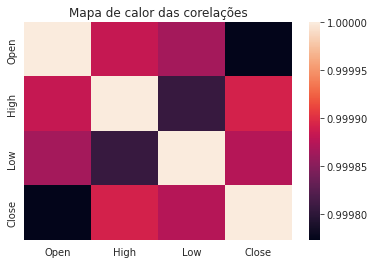

In [10]:
sns.heatmap(corr)
plt.title('Mapa de calor das corelações')

## Train/val/test split

In [11]:
def gen_seq(df, n_future, n_past):
    x = []
    y = []

    for i in range(n_past, len(df) - n_future +1):
        x.append(df[i-n_past:i, 0:df.shape[0]])
        y.append(df[i+n_future-1:i+n_future,0])
    x, y = np.array(x), np.array(y)
    return x, y

In [14]:
##tuneble parameters
TRAIN_PCT = 0.8
TRAIN_VAL_PCT = 0.1

full_size = features_scaled.shape[0]

train = features_scaled[:int(TRAIN_PCT*full_size)]
test = features_scaled[int(TRAIN_PCT*full_size):]

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (12124, 4)
Test: (3031, 4)


In [15]:
##tuneble parameters
N_FUTURE = 1
N_PASS = 14

multi_variante_train_x, train_y = gen_seq(train, N_FUTURE, N_PASS)
multi_variante_test_x, test_y = gen_seq(test, N_FUTURE, N_PASS)

single_variante_train_x = multi_variante_train_x[:,:,0]
single_variante_test_x = multi_variante_test_x[:,:,0]

single_variante_train_x = np.reshape(single_variante_train_x, (single_variante_train_x.shape[0],1, single_variante_train_x.shape[1]))
single_variante_test_x = np.reshape(single_variante_test_x, (single_variante_test_x.shape[0],1, single_variante_test_x.shape[1]))

print('------SINGLE VARIANTE------')
print(f'train_x shape {single_variante_train_x.shape}')
print(f'train_y shape {train_y.shape}')
print('-------------------------')
print(f'test_x shape {single_variante_test_x.shape}')
print(f'test_y shape {test_y.shape}')
print('\n')
print('------MULTI VARIANTE------')
print(f'train_x shape {multi_variante_train_x.shape}')
print(f'train_y shape {train_y.shape}')
print('-------------------------')
print(f'test_x shape {multi_variante_test_x.shape}')
print(f'test_y shape {test_y.shape}')

------SINGLE VARIANTE------
train_x shape (12110, 1, 14)
train_y shape (12110, 1)
-------------------------
test_x shape (3017, 1, 14)
test_y shape (3017, 1)


------MULTI VARIANTE------
train_x shape (12110, 14, 4)
train_y shape (12110, 1)
-------------------------
test_x shape (3017, 14, 4)
test_y shape (3017, 1)


## Single variante

In [16]:
model_1 = Sequential()
model_1.add(SimpleRNN(32, input_shape=(None,single_variante_train_x.shape[-1]), return_sequences=True))
model_1.add(SimpleRNN(16, return_sequences=False))
model_1.add(Dropout(0.2))
model_1.add(Dense(train_y.shape[1]) )

model_1.compile(optimizer="adam", loss='mse')
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          1504      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_1 = model_1.fit(single_variante_train_x, train_y, epochs=200, batch_size=16, validation_split=TRAIN_VAL_PCT, verbose=1,)

Epoch 1/200
682/682 [==============================] - 4s 6ms/step - loss: 0.0390 - val_loss: 0.0065
Epoch 2/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0217 - val_loss: 0.0043
Epoch 3/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0210 - val_loss: 0.0029
Epoch 4/200
682/682 [==============================] - 4s 6ms/step - loss: 0.0211 - val_loss: 0.0058
Epoch 5/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0197 - val_loss: 0.0048
Epoch 6/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0204 - val_loss: 0.0043
Epoch 7/200
682/682 [==============================] - 4s 6ms/step - loss: 0.0194 - val_loss: 0.0046
Epoch 8/200
682/682 [==============================] - 4s 6ms/step - loss: 0.0202 - val_loss: 0.0076
Epoch 9/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0199 - val_loss: 0.0043
Epoch 10/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0206 - val_lo

Epoch 161/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0174 - val_loss: 0.0029
Epoch 162/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0018
Epoch 163/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0181 - val_loss: 0.0025
Epoch 164/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0167 - val_loss: 0.0035
Epoch 165/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0057
Epoch 166/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0175 - val_loss: 0.0056
Epoch 167/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0182 - val_loss: 0.0025
Epoch 168/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0017
Epoch 169/200
682/682 [==============================] - 4s 5ms/step - loss: 0.0170 - val_loss: 0.0038
Epoch 170/200
682/682 [==============================] - 4s 5ms/step - lo

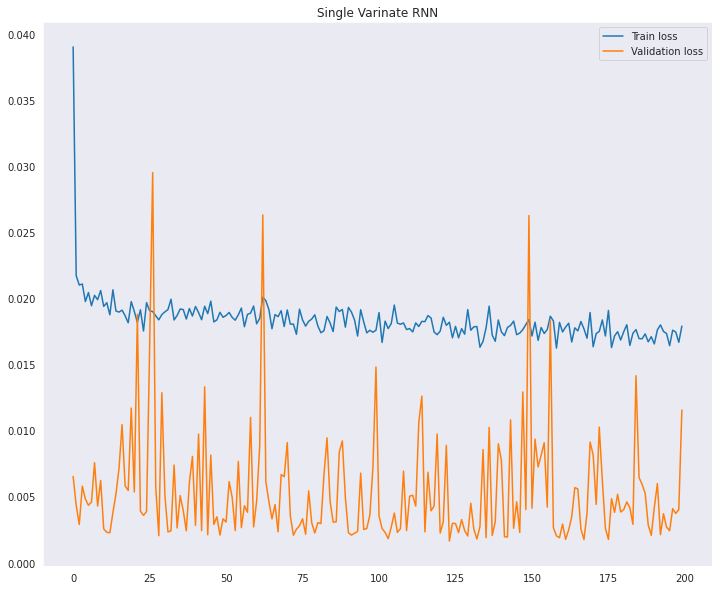

In [18]:
plt.figure(figsize=(12,10))
plt.plot(history_1.history['loss'], label ='Train loss')
plt.plot(history_1.history['val_loss'], label ='Validation loss')
plt.title("Single Varinate RNN")
plt.legend()

In [19]:
model_2 = Sequential()
model_2.add(LSTM(32, activation='relu', input_shape=(None,single_variante_train_x.shape[-1]), return_sequences=True))
model_2.add(LSTM(16, activation='relu', return_sequences=False))
model_2.add(Dropout(0.2))
model_2.add(Dense(train_y.shape[1]) )

model_2.compile(optimizer="adam", loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          6016      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 9,169
Trainable params: 9,169
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_2 = model_2.fit(single_variante_train_x, train_y, epochs=200, batch_size=16, validation_split=TRAIN_VAL_PCT, verbose=1,)

Epoch 1/200
682/682 [==============================] - 6s 9ms/step - loss: 0.1461 - val_loss: 0.0100
Epoch 2/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0600 - val_loss: 0.0106
Epoch 3/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0569 - val_loss: 0.0127
Epoch 4/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0552 - val_loss: 0.0059
Epoch 5/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0500 - val_loss: 0.0404
Epoch 6/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0466 - val_loss: 0.0036
Epoch 7/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0376 - val_loss: 0.0605
Epoch 8/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0421 - val_loss: 0.0203
Epoch 9/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0379 - val_loss: 0.0188
Epoch 10/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0367 - val_lo

Epoch 161/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0319 - val_loss: 0.0230
Epoch 162/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0313 - val_loss: 0.0031
Epoch 163/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0295 - val_loss: 0.0088
Epoch 164/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0305 - val_loss: 0.0034
Epoch 165/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0300 - val_loss: 0.0021
Epoch 166/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0317 - val_loss: 0.0019
Epoch 167/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0302 - val_loss: 0.0109
Epoch 168/200
682/682 [==============================] - 6s 8ms/step - loss: 0.0315 - val_loss: 0.0019
Epoch 169/200
682/682 [==============================] - 6s 9ms/step - loss: 0.0308 - val_loss: 0.0019
Epoch 170/200
682/682 [==============================] - 6s 8ms/step - lo

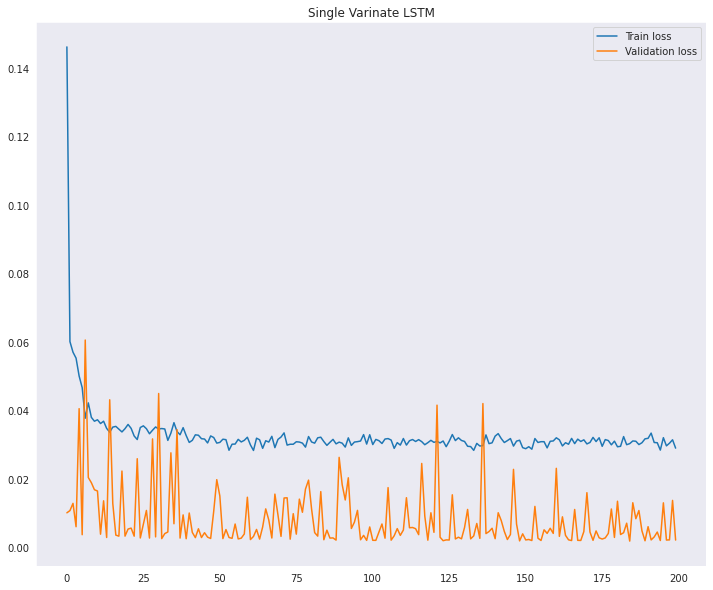

In [21]:
plt.figure(figsize=(12,10))
plt.plot(history_2.history['loss'], label ='Train loss')
plt.plot(history_2.history['val_loss'], label ='Validation loss')
plt.title("Single Varinate LSTM")
plt.legend()

## Multi varinate

In [22]:
model_3 = Sequential()
model_3.add(SimpleRNN(32, activation='relu', input_shape=(multi_variante_train_x.shape[1], multi_variante_train_x.shape[2]), return_sequences=True))
model_3.add(SimpleRNN(16, activation='relu', return_sequences=False))
model_3.add(Dropout(0.2))
model_3.add(Dense(train_y.shape[1]) )

model_3.compile(optimizer="adam", loss='mse')
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 14, 32)            1184      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_3 = model_3.fit(multi_variante_train_x, train_y, epochs=200, batch_size=16, validation_split=TRAIN_VAL_PCT, verbose=1,)

Epoch 1/200
682/682 [==============================] - 13s 19ms/step - loss: 0.3265 - val_loss: 0.0263
Epoch 2/200
682/682 [==============================] - 13s 19ms/step - loss: 0.1004 - val_loss: 0.0280
Epoch 3/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0750 - val_loss: 0.0058
Epoch 4/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0636 - val_loss: 0.0056
Epoch 5/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0648 - val_loss: 0.0115
Epoch 6/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0665 - val_loss: 0.0106
Epoch 7/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0617 - val_loss: 0.0179
Epoch 8/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 9/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0612 - val_loss: 0.0093
Epoch 10/200
682/682 [==============================] - 13s 19ms/step - l

682/682 [==============================] - 13s 19ms/step - loss: 0.0293 - val_loss: 8.3881e-04
Epoch 158/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0307 - val_loss: 0.0020
Epoch 159/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0335 - val_loss: 0.0016
Epoch 160/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0324 - val_loss: 0.0043
Epoch 161/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0316 - val_loss: 0.0032
Epoch 162/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0331 - val_loss: 0.0059
Epoch 163/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0331 - val_loss: 0.0068
Epoch 164/200
682/682 [==============================] - 13s 18ms/step - loss: 0.0329 - val_loss: 0.0085
Epoch 165/200
682/682 [==============================] - 13s 19ms/step - loss: 0.0317 - val_loss: 0.0074
Epoch 166/200
682/682 [==============================] - 13s 19ms

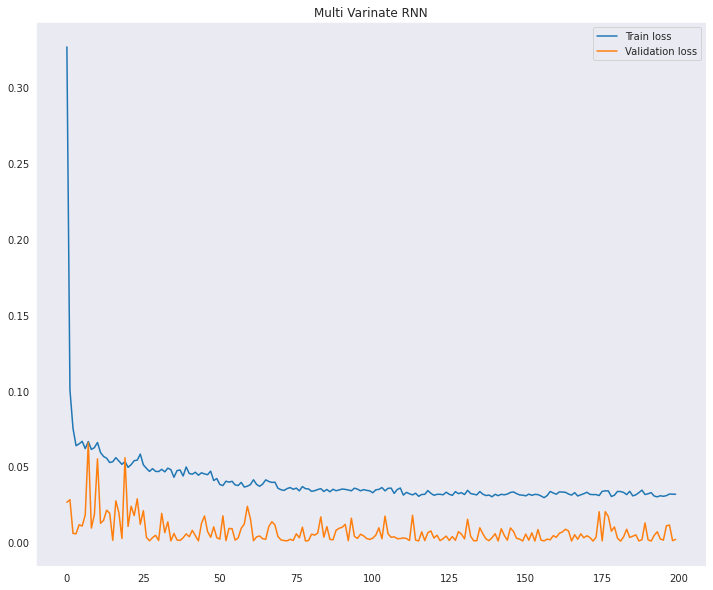

In [24]:
plt.figure(figsize=(12,10))
plt.plot(history_3.history['loss'], label ='Train loss')
plt.plot(history_3.history['val_loss'], label ='Validation loss')
plt.title("Multi Varinate RNN")
plt.legend()

In [25]:
model_4 = Sequential()
model_4.add(LSTM(32, activation='relu', input_shape=(multi_variante_train_x.shape[1], multi_variante_train_x.shape[2]), return_sequences=True))
model_4.add(LSTM(16, activation='relu', return_sequences=False))
model_4.add(Dropout(0.2))
model_4.add(Dense(train_y.shape[1]) )

model_4.compile(optimizer="adam", loss='mse')
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 14, 32)            4736      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 7,889
Trainable params: 7,889
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_4 = model_4.fit(multi_variante_train_x, train_y, epochs=200, batch_size=16, validation_split=TRAIN_VAL_PCT, verbose=1,)

Epoch 1/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0779 - val_loss: 0.0077
Epoch 2/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0423 - val_loss: 0.0044
Epoch 3/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0369 - val_loss: 0.0097
Epoch 4/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0342 - val_loss: 0.0110
Epoch 5/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0333 - val_loss: 0.0044
Epoch 6/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0323 - val_loss: 0.0148
Epoch 7/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0315 - val_loss: 0.0028
Epoch 8/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0322 - val_loss: 0.0042
Epoch 9/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0334 - val_loss: 0.0137
Epoch 10/200
682/682 [==============================] - 26s 38ms/step - l

682/682 [==============================] - 26s 37ms/step - loss: 0.0308 - val_loss: 0.0028
Epoch 158/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0326 - val_loss: 9.4116e-04
Epoch 159/200
682/682 [==============================] - 26s 37ms/step - loss: 0.0285 - val_loss: 0.0024
Epoch 160/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0316 - val_loss: 8.1041e-04
Epoch 161/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0296 - val_loss: 0.0073
Epoch 162/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0287 - val_loss: 0.0078
Epoch 163/200
682/682 [==============================] - 25s 37ms/step - loss: 0.0307 - val_loss: 8.7015e-04
Epoch 164/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0294 - val_loss: 0.0056
Epoch 165/200
682/682 [==============================] - 25s 37ms/step - loss: 0.0303 - val_loss: 0.0033
Epoch 166/200
682/682 [==============================] - 

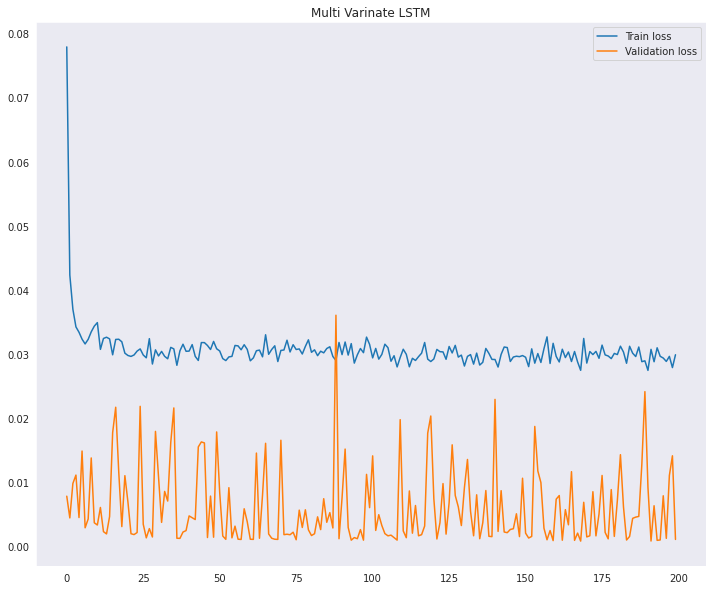

In [27]:
plt.figure(figsize=(12,10))
plt.plot(history_4.history['loss'], label ='Train loss')
plt.plot(history_4.history['val_loss'], label ='Validation loss')
plt.title("Multi Varinate LSTM")
plt.legend()

In [28]:
model_5 = Sequential()
model_5.add(LSTM(128, activation='relu', input_shape=(multi_variante_train_x.shape[1], multi_variante_train_x.shape[2]), return_sequences=True))
model_5.add(LSTM(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(16, activation='relu'))   
model_5.add(Dense(train_y.shape[1]))

model_5.compile(optimizer="adam", loss='mse')
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 128)           68096     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 208,993
Trainable params: 208,993
Non-trainable params: 0
________________________________________________

In [29]:
history_5 = model_5.fit(multi_variante_train_x, train_y, epochs=200, batch_size=16,validation_split=TRAIN_VAL_PCT, verbose=1,)

Epoch 1/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0298 - val_loss: 0.0197
Epoch 2/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 3/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 4/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 5/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 7/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0024 - val_loss: 0.0145
Epoch 8/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch 9/200
682/682 [==============================] - 26s 38ms/step - loss: 0.0020 - val_loss: 0.0147
Epoch 10/200
682/682 [==============================] - 26s 38ms/step - l

682/682 [==============================] - 26s 38ms/step - loss: 3.1077e-04 - val_loss: 0.0082
Epoch 153/200
682/682 [==============================] - 26s 38ms/step - loss: 2.9439e-04 - val_loss: 0.0087
Epoch 154/200
682/682 [==============================] - 26s 38ms/step - loss: 3.2981e-04 - val_loss: 0.0083
Epoch 155/200
682/682 [==============================] - 26s 38ms/step - loss: 2.7609e-04 - val_loss: 0.0084
Epoch 156/200
682/682 [==============================] - 26s 38ms/step - loss: 2.7634e-04 - val_loss: 0.0094
Epoch 157/200
682/682 [==============================] - 26s 38ms/step - loss: 3.0445e-04 - val_loss: 0.0068
Epoch 158/200
682/682 [==============================] - 26s 38ms/step - loss: 2.7727e-04 - val_loss: 0.0077
Epoch 159/200
682/682 [==============================] - 26s 38ms/step - loss: 2.9968e-04 - val_loss: 0.0089
Epoch 160/200
682/682 [==============================] - 26s 38ms/step - loss: 2.5705e-04 - val_loss: 0.0066
Epoch 161/200
682/682 [==========

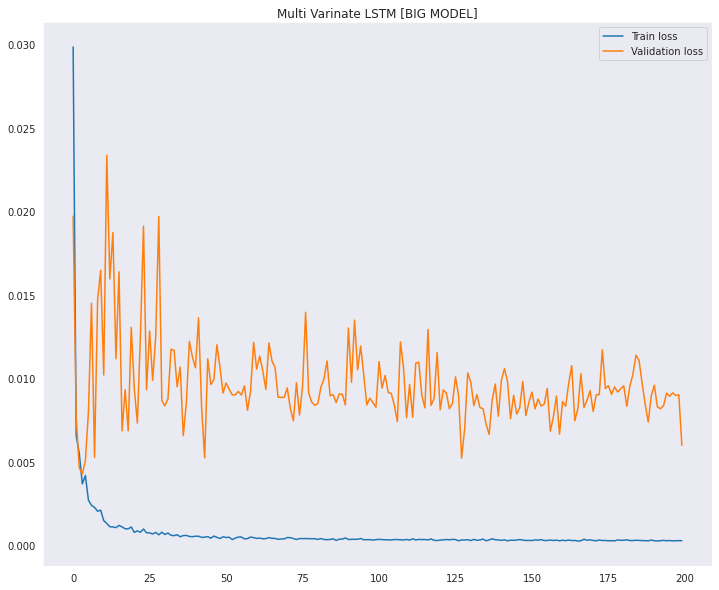

In [30]:
plt.figure(figsize=(12,10))
plt.plot(history_5.history['loss'], label ='Train loss')
plt.plot(history_5.history['val_loss'], label ='Validation loss')
plt.title("Multi Varinate LSTM [BIG MODEL]")
plt.legend()

### Training plot

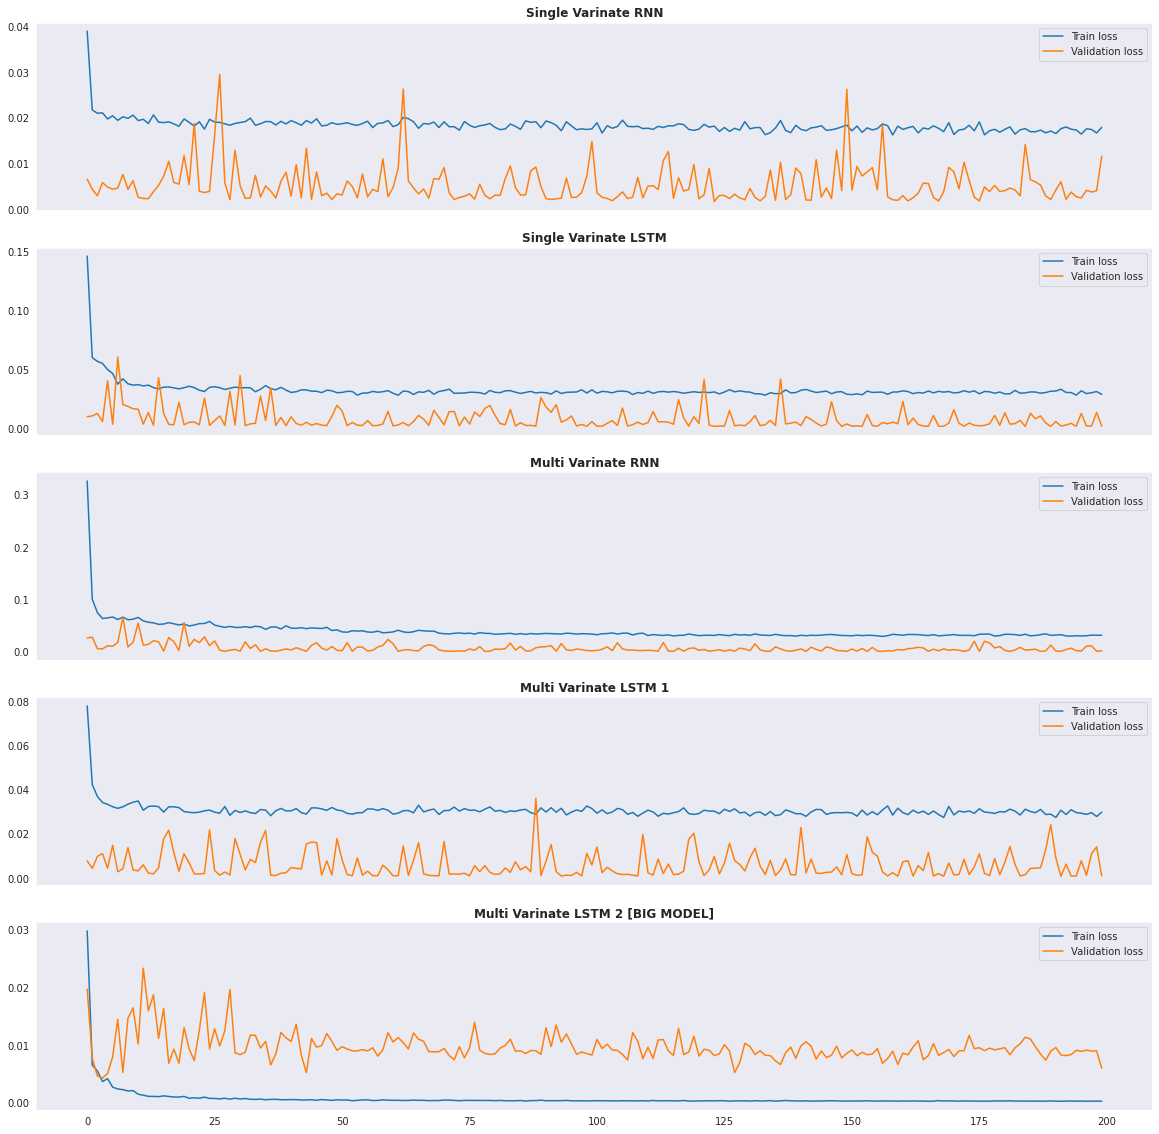

In [31]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(20,20), sharex=True)
# fig.suptitle('Training metrics')



# ax1.figure(figsize=(12,10))
ax1.plot(history_1.history['loss'], label ='Train loss')
ax1.plot(history_1.history['val_loss'], label ='Validation loss')
ax1.set_title("Single Varinate RNN", fontsize='large', fontweight='bold')
ax1.legend()

# ax2.figure(figsize=(12,10))
ax2.plot(history_2.history['loss'], label ='Train loss')
ax2.plot(history_2.history['val_loss'], label ='Validation loss')
ax2.set_title("Single Varinate LSTM", fontsize='large', fontweight='bold')
ax2.legend()

# ax3.figure(figsize=(12,10))
ax3.plot(history_3.history['loss'], label ='Train loss')
ax3.plot(history_3.history['val_loss'], label ='Validation loss')
ax3.set_title("Multi Varinate RNN", fontsize='large', fontweight='bold')
ax3.legend()

# ax4.figure(figsize=(12,10))
ax4.plot(history_4.history['loss'], label ='Train loss')
ax4.plot(history_4.history['val_loss'], label ='Validation loss')
ax4.set_title("Multi Varinate LSTM 1", fontsize='large', fontweight='bold')
ax4.legend()

# ax5.figure(figsize=(12,10))
ax5.plot(history_5.history['loss'], label ='Train loss')
ax5.plot(history_5.history['val_loss'], label ='Validation loss')
ax5.set_title("Multi Varinate LSTM 2 [BIG MODEL]", fontsize='large', fontweight='bold')
ax5.legend()

import matplotlib as mpl
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.savefig("Training_plots.png")

## Test

In [58]:
#sinlge variant
forecast_1 = model_1.predict(single_variante_test_x)
forecast_2 = model_2.predict(single_variante_test_x)
#multi variant
forecast_3 = model_3.predict(multi_variante_test_x)
forecast_4 = model_4.predict(multi_variante_test_x)
forecast_5 = model_5.predict(multi_variante_test_x)

test_y_copies = np.repeat(test_y, features_scaled.shape[1], axis=-1)
test_y_inverse = scaler.inverse_transform(test_y_copies)[:,0]

forecast_1copies = np.repeat(forecast_1, features_scaled.shape[1], axis=-1)
forecast_1= scaler.inverse_transform(forecast_1copies)[:,0]

forecast_2copies = np.repeat(forecast_2, features_scaled.shape[1], axis=-1)
forecast_2= scaler.inverse_transform(forecast_2copies)[:,0]

forecast_3_copies = np.repeat(forecast_3, features_scaled.shape[1], axis=-1)
forecast_3 = scaler.inverse_transform(forecast_3_copies)[:,0]

forecast_4_copies = np.repeat(forecast_4, features_scaled.shape[1], axis=-1)
forecast_4 = scaler.inverse_transform(forecast_4_copies)[:,0]

forecast_5_copies = np.repeat(forecast_5, features_scaled.shape[1], axis=-1)
forecast_5 = scaler.inverse_transform(forecast_5_copies)[:,0]

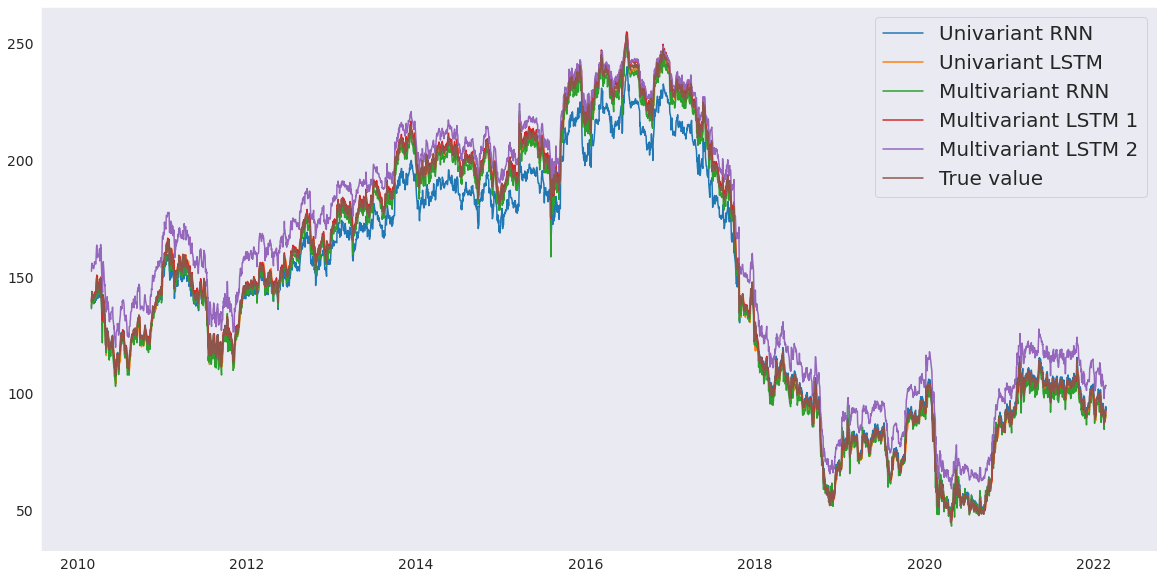

In [77]:
size_date = df_dates.shape[0]
dates_to_plot = df_dates[int(0.8*size_date):-14]
plt.figure(figsize=(20,10))

plt.plot(dates_to_plot, forecast_1)
plt.plot(dates_to_plot, forecast_2)
plt.plot(dates_to_plot, forecast_3)
plt.plot(dates_to_plot, forecast_4)
plt.plot(dates_to_plot, forecast_5)
plt.plot(dates_to_plot, test_y_inverse)

import matplotlib as mpl
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['legend.fontsize'] = 20
plt.legend(['Univariant RNN', 'Univariant LSTM', 'Multivariant RNN', 'Multivariant LSTM 1', 'Multivariant LSTM 2', 'True value'])

# plt.savefig("results_plots.png")

In [75]:
from sklearn.metrics import mean_squared_error
test_score_1 = np.sqrt(mean_squared_error(test_y_inverse, forecast_1))
test_score_2 = np.sqrt(mean_squared_error(test_y_inverse, forecast_2))
test_score_3 = np.sqrt(mean_squared_error(test_y_inverse, forecast_3))
test_score_4 = np.sqrt(mean_squared_error(test_y_inverse, forecast_4))
test_score_5 = np.sqrt(mean_squared_error(test_y_inverse, forecast_5))

print('MSE Metrics')
print(f'model 1 RNN score: {test_score_1}')
print(f'model 2 LSTM score: {test_score_2}')
print(f'model 3 RNN score: {test_score_3}')
print(f'model 4 LSTM 1 score: {test_score_4}')
print(f'model 5 LSTM 2 score: {test_score_5}')

MSE Metrics
model 1 RNN score: 9.264306067085753
model 2 LSTM score: 2.907860295391224
model 3 RNN score: 3.107755414379447
model 4 LSTM 1 score: 1.9788922753895484
model 5 LSTM 2 score: 10.707621607294966
